In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [21]:
ex =  torch.load('ex.pt')
control =  torch.load('cond7.pt')
sd =  torch.load('sd.pt')
eucli_centroid = torch.load('cond7_centroid.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_22776\509564176.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex =  torch.load('ex.pt')
C:\Users\k54739\AppData\Local\Temp

In [22]:
print(ex.shape)
print(control.shape)
print(sd.shape)
print(eucli_centroid.shape)


torch.Size([40, 27648])
torch.Size([280, 27648])
torch.Size([103, 27648])
torch.Size([1, 27648])


In [23]:
import torch
import matplotlib.pyplot as plt

def calculate_and_plot_eucli_distances(centroid, groups, group_names, bins=20):
    """
    Calculate cosine distances from a centroid to each vector in multiple groups and plot distributions.
    
    Args:
        centroid (torch.Tensor): Normalized centroid tensor of shape [1, D].
        groups (list of torch.Tensor): List of normalized tensors, each group of shape [N, D].
        group_names (list of str): Names of the groups (e.g., ["Control", "Exploded", "Single Dose"]).
        bins (int): Number of bins for the histogram.
        
    Returns:
        dict: Dictionary containing cosine distances for each group.
    """
    assert len(groups) == len(group_names), "Each group must have a corresponding name"
    
    eucli_distances = {}
    
    # Calculate cosine distances for each group
    for group, name in zip(groups, group_names):
        # Ensure the centroid and group are on the same device
        centroid = centroid.to(group.device)
        
        # Calculate cosine similarity
        distances = torch.norm(group - centroid.expand_as(group), dim=1)
        
       
        
        # Store distances
        eucli_distances[name] = distances.cpu().numpy()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    for name, distances in eucli_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=name, edgecolor="black")
    
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()
    
    return eucli_distances


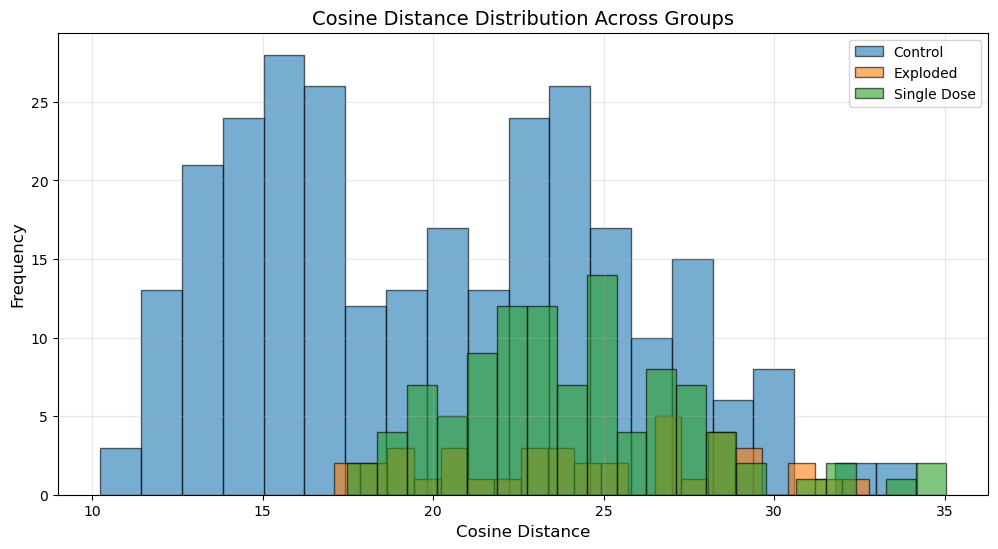

In [24]:
# Groups and names
groups = [control, ex, sd]
group_names = ["Control", "Exploded", "Single Dose"]

# Calculate distances and plot
eucli_distances = calculate_and_plot_eucli_distances(
    centroid=eucli_centroid,
    groups=groups,
    group_names=group_names,
    bins=20
)

# Access calculated distances
control_distances = eucli_distances["Control"]
exploded_distances = eucli_distances["Exploded"]
single_dose_distances = eucli_distances["Single Dose"]

In [25]:
control_distances.shape

(280,)

In [26]:
exploded_distances.shape

(40,)

In [27]:
single_dose_distances.shape

(103,)

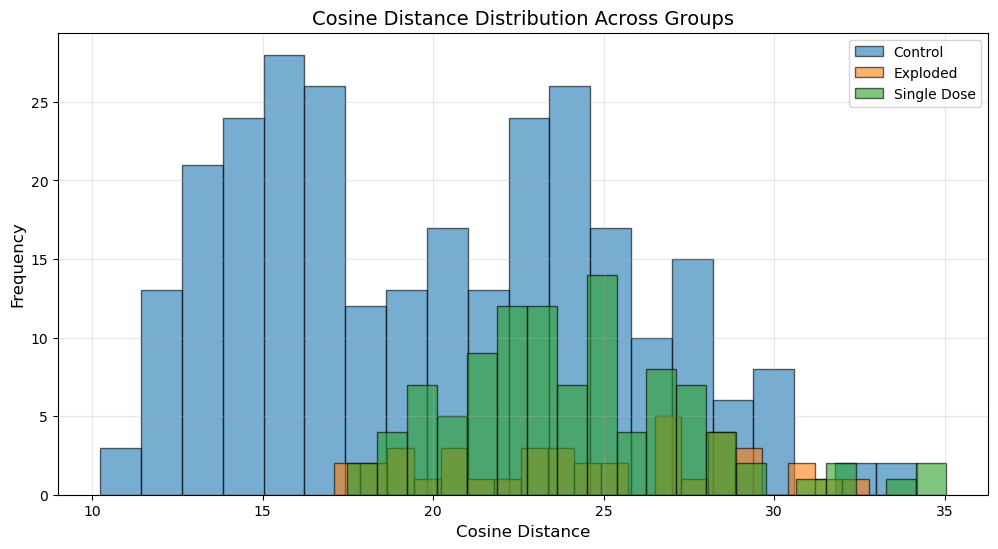


Metrics:
Group-Wise Ranking Accuracy: 0.7844

Cosine Distances:
Control: [20.93250125 33.10246029 29.52545376 19.08381689 12.77361173] ...
Exploded: [31.14827583 30.83961937 26.83553527 26.88927047 28.90562653] ...
Single Dose: [25.26605538 25.47147671 21.9456565  26.32559184 28.73601965] ...

Group-Wise Ranking Accuracy: 0.7844


In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_cosine_distances(centroid, groups, group_names, bins=20):
    """
    Calculate cosine distances from a centroid to each vector in multiple groups,
    plot distributions, and compute Group-Wise Ranking Accuracy.
    
    Args:
        centroid (torch.Tensor): Normalized centroid tensor of shape [1, D].
        groups (list of torch.Tensor): List of normalized tensors, each group of shape [N, D].
        group_names (list of str): Names of the groups (e.g., ["Control", "Exploded", "Single Dose"]).
        bins (int): Number of bins for the histogram.
        
    Returns:
        dict: Dictionary containing cosine distances for each group and metrics.
    """
    assert len(groups) == len(group_names), "Each group must have a corresponding name"
    
    cosine_distances = {}
    
    # Calculate cosine distances for each group
    for group, name in zip(groups, group_names):
        # Ensure the centroid and group are on the same device
        centroid = centroid.to(group.device)
        
        # Calculate cosine similarity
        distances = torch.norm(group- centroid.expand_as(group), dim=1)
        
        
        
        
        # Store distances
        cosine_distances[name] = distances.cpu().numpy()
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    for name, distances in cosine_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=name, edgecolor="black")
    
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()
    
    # Compute Group-Wise Ranking Accuracy
    group_wise_accuracy = compute_group_wise_ranking_accuracy(cosine_distances, group_names)
    
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")
    
    return {
        "cosine_distances": cosine_distances,
        "group_wise_accuracy": group_wise_accuracy
    }

def compute_group_wise_ranking_accuracy(cosine_distances, group_names):
    """
    Compute the Group-Wise Ranking Accuracy metric.
    
    Args:
        cosine_distances (dict): Dictionary of cosine distances for each group.
        group_names (list of str): Names of the groups in ranking order.
        
    Returns:
        float: Group-wise ranking accuracy.
    """
    # Assign numerical labels to each group based on the order of group_names
    all_distances = []
    all_labels = []
    
    for i, name in enumerate(group_names):
        distances = cosine_distances[name]
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign label i to this group
    
    # Combine all distances and labels
    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]
    
    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1
    
    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy


# Groups and names
groups = [control, ex, sd]
group_names = ["Control", "Exploded", "Single Dose"]

# Calculate distances, plot, and get metrics
results = calculate_and_plot_cosine_distances(
    centroid=eucli_centroid,
    groups=groups,
    group_names=group_names,
    bins=20
)

# Access results
cosine_distances = results["cosine_distances"]
group_wise_accuracy = results["group_wise_accuracy"]

# Print results
print("\nCosine Distances:")
for group, distances in cosine_distances.items():
    print(f"{group}: {distances[:5]} ...")  # Print first 5 distances for brevity
print(f"\nGroup-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")
